In this blog, we will implement ```k-fold``` cross-validation for a linear regression model in Julia. I have taken the datasets from the ``ISLR`` datasets, which is part of the ``RDatasets`` package. To know more about cross-validation techniques, please read Chapter 5 of "An Introduction to Statistical Learning" by James et al. Other types of validation techniques such as LOOCV, validation set approach etc. can be implemented similarly.

We start by loading the necessary packages. 

In [1]:
# first we load the necessary packages

using RDatasets, DataFrames, Random, LinearAlgebra, MultivariateStats, Statistics

Let us load the ``Auto`` dataset from ``ISLR`` datasets, and observe what are the quantities in the dataframe.

In [2]:
df = dataset("ISLR", "Auto")

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
2,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
3,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
4,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
5,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0
6,15.0,8.0,429.0,198.0,4341.0,10.0,70.0,1.0
7,14.0,8.0,454.0,220.0,4354.0,9.0,70.0,1.0
8,14.0,8.0,440.0,215.0,4312.0,8.5,70.0,1.0
9,14.0,8.0,455.0,225.0,4425.0,10.0,70.0,1.0


In the table above, we have columns such as ``MPG``, ``Cylinders``, ``Displacement`` etc. For our experiment, we want to predict ``MPG`` as a linear function of the following input variables: ``Cylinders``, ``Displacement``, ``Horsepower``, ``Weight``, and ``Acceleration``. 

Now, let us see how many observations we have in our dataframe ``df``. The number of observations is denoted by $n_\textrm{rows}$.

In [3]:
n_rows = size(df)[1] # number of rows i.e., observations in the dataset

392

We record form ``Wikipedia`` the following facts about k-fold cross-validation.


>In K-fold cross-validation, the original sample is randomly partitioned into K equal sized subsamples. Of the K subsamples, a single subsample is retained as the validation data for testing the model, and the remaining K − 1 subsamples are used as training data. The cross-validation process is then repeated K times, with each of the K subsamples used exactly once as the validation data. The K results can then be averaged to produce a single estimation. 

So the first stage is randomly sampling ``df``. To that goal, we randomly shuffle the rows of ``df``. After that, we will pick equal sized subsamples in a sequential manner. In our case, value of $K=10$. In each of the $K$ groups, we select $n_G = \lceil n_\textrm{rows}/K \rfloor$ number of observations for *testing* and $K n_G - n_G$ of obsesrvations for *training*. In process, we will be losing $n_\textrm{rows} - Kn_G$ number of observations. Denote $n = K*n_G$, which is the total number of effective observations used in our training and testing procedure.

In [4]:
df = df[shuffle(1:n_rows),:] 
# The function shuffle return a randomly permuted copy of the the 
# input vector. So, in our case it randomly shuffles the rows of the 
# original dataframe df. This is done in order to create random 
# test and training set from our data.

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,25.5,4.0,122.0,96.0,2300.0,15.5,77.0,1.0
2,26.8,6.0,173.0,115.0,2700.0,12.9,79.0,1.0
3,19.4,6.0,232.0,90.0,3210.0,17.2,78.0,1.0
4,27.4,4.0,121.0,80.0,2670.0,15.0,79.0,1.0
5,24.0,4.0,90.0,75.0,2108.0,15.5,74.0,2.0
6,23.0,6.0,198.0,95.0,2904.0,16.0,73.0,1.0
7,29.0,4.0,97.0,78.0,1940.0,14.5,77.0,2.0
8,20.0,4.0,140.0,90.0,2408.0,19.5,72.0,1.0
9,24.2,6.0,146.0,120.0,2930.0,13.8,81.0,3.0


In the shuffled dataframe, the rows are indeed have changed their orders randomly.

In [5]:
K = 10 # K is 10, so we are going to do a 10-fold cross validation

10

In [6]:
n_G = Int(floor(n_rows/K)) # so each of the K groups will have nG number of
# elements for testing, and K*nG - nG elements for training

39

In [7]:
n = K*n_G # in the end we will end up covering n number of observations
# unfortunately we will end up losing a certain number observations

390

In [8]:
n-n_G

351

In [9]:
n_lost = size(df)[1] - n # so we lost 2 observation in the process

2

In [10]:
function indices_test_set(k)  
    # This is a function that takes 
    # an integer k = 1, 2, ..., K, and outputs a index set corresponding to the test set. 
    # For example, in our case, 
    # indices_test_set(1) will pick the indices corresponding to the first n_G observations of the
    # shuffled dataframe df, indices_test_set(2) will pick the next n_G observations and so on.
    return collect(1+n_G*(k-1):n_G*k) 
end

indices_test_set (generic function with 1 method)

In [11]:
function indices_training_set(k)
    # indices_training_set(k) will remove the indices for elements 
    # of indices_test_set(k) from 
    # the shuffled dataset df. We train our k-th regression model on 
    # the training set for k in 1:K
    return setdiff(1:n, indices_test_set(k))
end

indices_training_set (generic function with 1 method)

In [12]:
function y_test_set(k)
    # we are creating the response vector corresponding to the test set, 
    # which is the element MPG. Here we are ensuring that we 
    # only pick the elements associated with the k-th test set that
    # are related to  the variable :MPG
    return convert(Array{Float64,1},df[indices_test_set(k),:MPG])
end

y_test_set (generic function with 1 method)

In [13]:
function y_training_set(k)
    # similar to y_test_set() function, but corresponds to the training set response 
    # vector now
    return convert(Array{Float64,1},df[indices_training_set(k),:MPG]) 
end

y_training_set (generic function with 1 method)

In [14]:
variable_array = [:Cylinders, :Displacement, :Horsepower, :Weight, :Acceleration]
# we are creating an array that corresponds to the input variables for our regression
# model

5-element Array{Symbol,1}:
 :Cylinders   
 :Displacement
 :Horsepower  
 :Weight      
 :Acceleration

In [15]:
n_var = length(variable_array)

5

In [16]:
function X_test_set(k)
    # in the input data set, we are assuming that the response :MPG 
    # depends affine-ly on the following variables:
    # Cylinders, Displacement, Horsepower, Weight, Acceleration
    variable_array = [:Cylinders, :Displacement, :Horsepower, :Weight, :Acceleration]
    return convert(Array{Float64,2},df[indices_test_set(k), variable_array])
end

X_test_set (generic function with 1 method)

In [17]:
function X_training_set(k)
    # similar to the test data set, used for training the 
    # k-th training set
    variable_array = [:Cylinders, :Displacement, :Horsepower, :Weight, :Acceleration]
    return convert(Array{Float64,2}, df[indices_training_set(k), variable_array])
end

X_training_set (generic function with 1 method)

For each of the $K$ training datasets, we run linear regression, for $k = 1, 2, \ldots, K$. Then, for the output for $k$th training set, we compute the mean-squared-errror for $k$th test set. We assume that, the response vector $y$ is an affine function of our variables (parameters) $a\in\mathbf{R}^n$ and $b\in \mathbf{R}$: 
\begin{equation}
y = X a + b \mathbf{1},
\end{equation}
where $X$ is the data matrix used.


For linear regression, we will be using the package ``MultivariateStats`` and its function ``llsq``. The function ``llsq``, as recorded in the documentation of ``MultivariateStats.jl``, works as follows. 

>Linear Least Square finds linear combination(s) of given variables to fit the responses by minimizing the squared error between them. This can be formulated as an optimization as follows:
$$
\mathop{\mathrm{minimize}}_{(\mathbf{a}, b)} \
\frac{1}{2} \|\mathbf{y} - (\mathbf{X} \mathbf{a} + b \mathbf{1})\|^2,
$$
where $a \in \mathbf{R}^n, b \in \mathbf{R}$ are the decision variables, and $X$ is the data matrix corresponding to a particular training set, and $y$ is the response vector corresponding to that training set. The package provides ``llsq`` to solve these problems:
```function:: llsq(X, y; ...)``` solves the linear least square problem formulated above. The function results the solution ``[a; b]``

Now we run the following code for to run linear regression, and then compute the mean squared error for each of the $K$ test sets.

In [18]:
# Time to run the Linear Regression for each of the K sets 
a_array = zeros(n_var,K) 
y_predicted = zeros()
b_array = zeros(K) 
mse_array_training = zeros(K) # mse = mean squared error 
mse_array_test = zeros(K)
# vector a for k th training set is a_array(:,k), and 
# scalar b for the k th training set is b_array(k)
for k in 1:K
    sol = llsq(X_training_set(k), y_training_set(k))
    a_array[:,k], b_array[k] = sol[1:end-1,:], sol[end, :][1]
    # predicted y and mean squared error for k-th training set 
    y_prediced_k_training = X_training_set(k)*a_array[:,k] + b_array[k]*ones(n-n_G)
    mse_array_training[k] = norm(y_training_set(k) - y_prediced_k_training)^2/(n-n_G)
    # predict what the response y is for the k th test set     
    y_predicted_k_test = X_test_set(k)*a_array[:,k] + b_array[k]*ones(n_G)
    # mean square error tested on k-th test set
    mse_array_test[k] = norm(y_test_set(k)-y_predicted_k_test)^2/n_G
end

Now let us see, how the training mse and test mse compares for the $K$ folds. As shown in the blocks below, they are of the same order, thus giving us hope that our choice of parameters will generalize reasonably well.

In [19]:
mse_array_test

10-element Array{Float64,1}:
 21.05079609045843 
 16.914179663272158
 14.978484708125757
 31.054740853916563
 14.440598457429331
 16.279789405087254
 14.897713943774969
 12.226727605260086
 22.259054706181516
 22.967637533450905

In [20]:
mse_array_training

10-element Array{Float64,1}:
 17.553911326418394
 17.98670251311746 
 18.1965031926724  
 16.445938803393048
 18.263017899162932
 18.09478276636446 
 18.200272808421403
 18.516614015839494
 17.450105015872655
 17.341128880271942

In the end we have 10 different pairs of $[a b]$ parameters. The final question is which one to use? When things are going well, these values should not differ too much, so the choice should not matter too much either in a sunny day scenario. Let's see if that is indeed the case for our problem instance in consideration. In the dataframes below the $k$-th column corresponds to $a$ vector and $b$ scalar (bias) for $k$-th training set, respectively.

In [21]:
println( convert(DataFrame, a_array))

5×10 DataFrame
│ Row │ x1          │ x2          │ x3         │ x4          │ x5         │ x6          │ x7          │ x8          │ x9          │ x10         │
│     │ Float64     │ Float64     │ Float64    │ Float64     │ Float64    │ Float64     │ Float64     │ Float64     │ Float64     │ Float64     │
├─────┼─────────────┼─────────────┼────────────┼─────────────┼────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ 1   │ -0.431721   │ -0.457843   │ -0.464515  │ -0.342758   │ -0.52949   │ -0.31526    │ -0.376163   │ -0.305981   │ -0.337071   │ -0.415233   │
│ 2   │ 0.00676299  │ 0.00351145  │ 0.00158696 │ 0.00199585  │ -7.0383e-5 │ -0.00619317 │ 0.000587922 │ 0.00145024  │ -0.00719366 │ -0.00460473 │
│ 3   │ -0.0518277  │ -0.0472051  │ -0.0460186 │ -0.0500283  │ -0.0475639 │ -0.0463784  │ -0.0388479  │ -0.0521594  │ -0.0426643  │ -0.0319668  │
│ 4   │ -0.00576871 │ -0.00529121 │ -0.0051606 │ -0.00511359 │ -0.0050306 │ -0.00474927 │ -0.00547187 │ -0.00

In [22]:
println( convert(DataFrame, b_array'))

1×10 DataFrame
│ Row │ x1      │ x2      │ x3      │ x4      │ x5      │ x6      │ x7      │ x8      │ x9      │ x10     │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 47.8073 │ 46.3193 │ 45.3659 │ 44.915  │ 47.8659 │ 47.6221 │ 44.9804 │ 46.2839 │ 46.4757 │ 45.2124 │


Note that, the parameters are roughly the same for different training sets. Now, how to come up with a final choice of parameters $a$ and $b$? One reasonable choice is to use the average of the model parameters from the different training sets.

In [23]:
a_array_final = mean(a_array, dims=2)

5×1 Array{Float64,2}:
 -0.39760361004512057   
 -0.00021665187670510358
 -0.045466039019354865  
 -0.005165344527557736  
 -0.03177316550390949   

In [24]:
b_final = mean(b_array)

46.284784836274596

Lets see how our final parameters fit. We will do so by creating a scatter plot of actual and predicted `MPG`.

In [25]:
using Plots

In [26]:
X_all = convert(Array{Float64,2},df[1:n_rows, variable_array]);
y_all = convert(Array{Float64},df[1:n_rows, :MPG]);
y_predicted_all = X_all*a_array_final + b_final*ones(n_rows);
maximum(y_all)

46.6

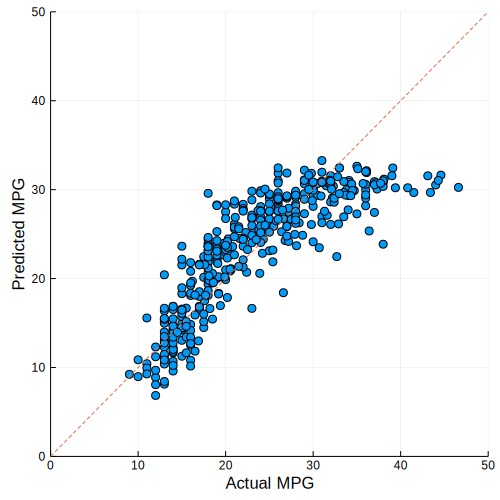

In [27]:
y_lim = 50
scatter(y_all, y_predicted_all, lims = (0, y_lim))
plot!([0, y_lim], [0, y_lim], linestyle = :dash, legend = false)
plot!(xlims = (0,y_lim), ylims = (0,y_lim), size = (500,500))
plot!(xlabel = "Actual MPG", ylabel = "Predicted MPG")

It seems that our model does not do a bad job. However, it also shows that perhaps we could have a better assumption regarding our choice of model than the current one ($y = X a + b \mathbf{1}$). But, that is another topic, which I will come back to a later point.  